#### 5.2.3 교차 검증을 사용한 그리드 서치

- 그리드 탐색에서도 교차 검증 필요
  - 위 두 예제에서 최고의 성능을 보여주는 파라미터가 변경된 점을 주의
  - cross_val_score 사용

In [1]:
%matplotlib inline
import sys 
sys.path.append('..')
from preamble import *
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# naive grid search implementation
from sklearn.svm import SVC
from sklearn.datasets import load_iris
iris = load_iris()

In [4]:
from sklearn.model_selection import cross_val_score
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)
best_score = 0

print("Size of training set: {}, size of validation set: {},size of test set: {}\n".format(
    X_train.shape[0], 
    X_valid.shape[0], 
    X_test.shape[0]))

# reference: manual_grid_search_cv
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters,
        # train an SVC
        svm = SVC(gamma=gamma, C=C)
        # perform cross-validation
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        # compute mean cross-validation accuracy
        score = np.mean(scores)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
# rebuild a model on the combined training and validation set
svm = SVC(**best_parameters)

#[NOTE] 훈련 데이터와 검증 데이터를 합쳐서 다시 모델을 구성함
svm.fit(X_trainval, y_trainval)

test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of training set: 84, size of validation set: 28,size of test set: 38

Best score on validation set: 0.97
Best parameters:  {'C': 100, 'gamma': 0.01}
Test set score with best parameters: 0.97


- 위 예에서는 반복적인 모델 생성 작업이 6 \* 6 \* 5 = 180번 이루어짐
  - 즉, 시간이 많이 소요됨에 주의

- 아래 그림은 교차 검증에 5-fold 사용
- 매개변수 그리드는 일부만 표시
- 교차 검증 5번의 평균이 가장 높은 매개변수를 빨간 동그라미로 표시

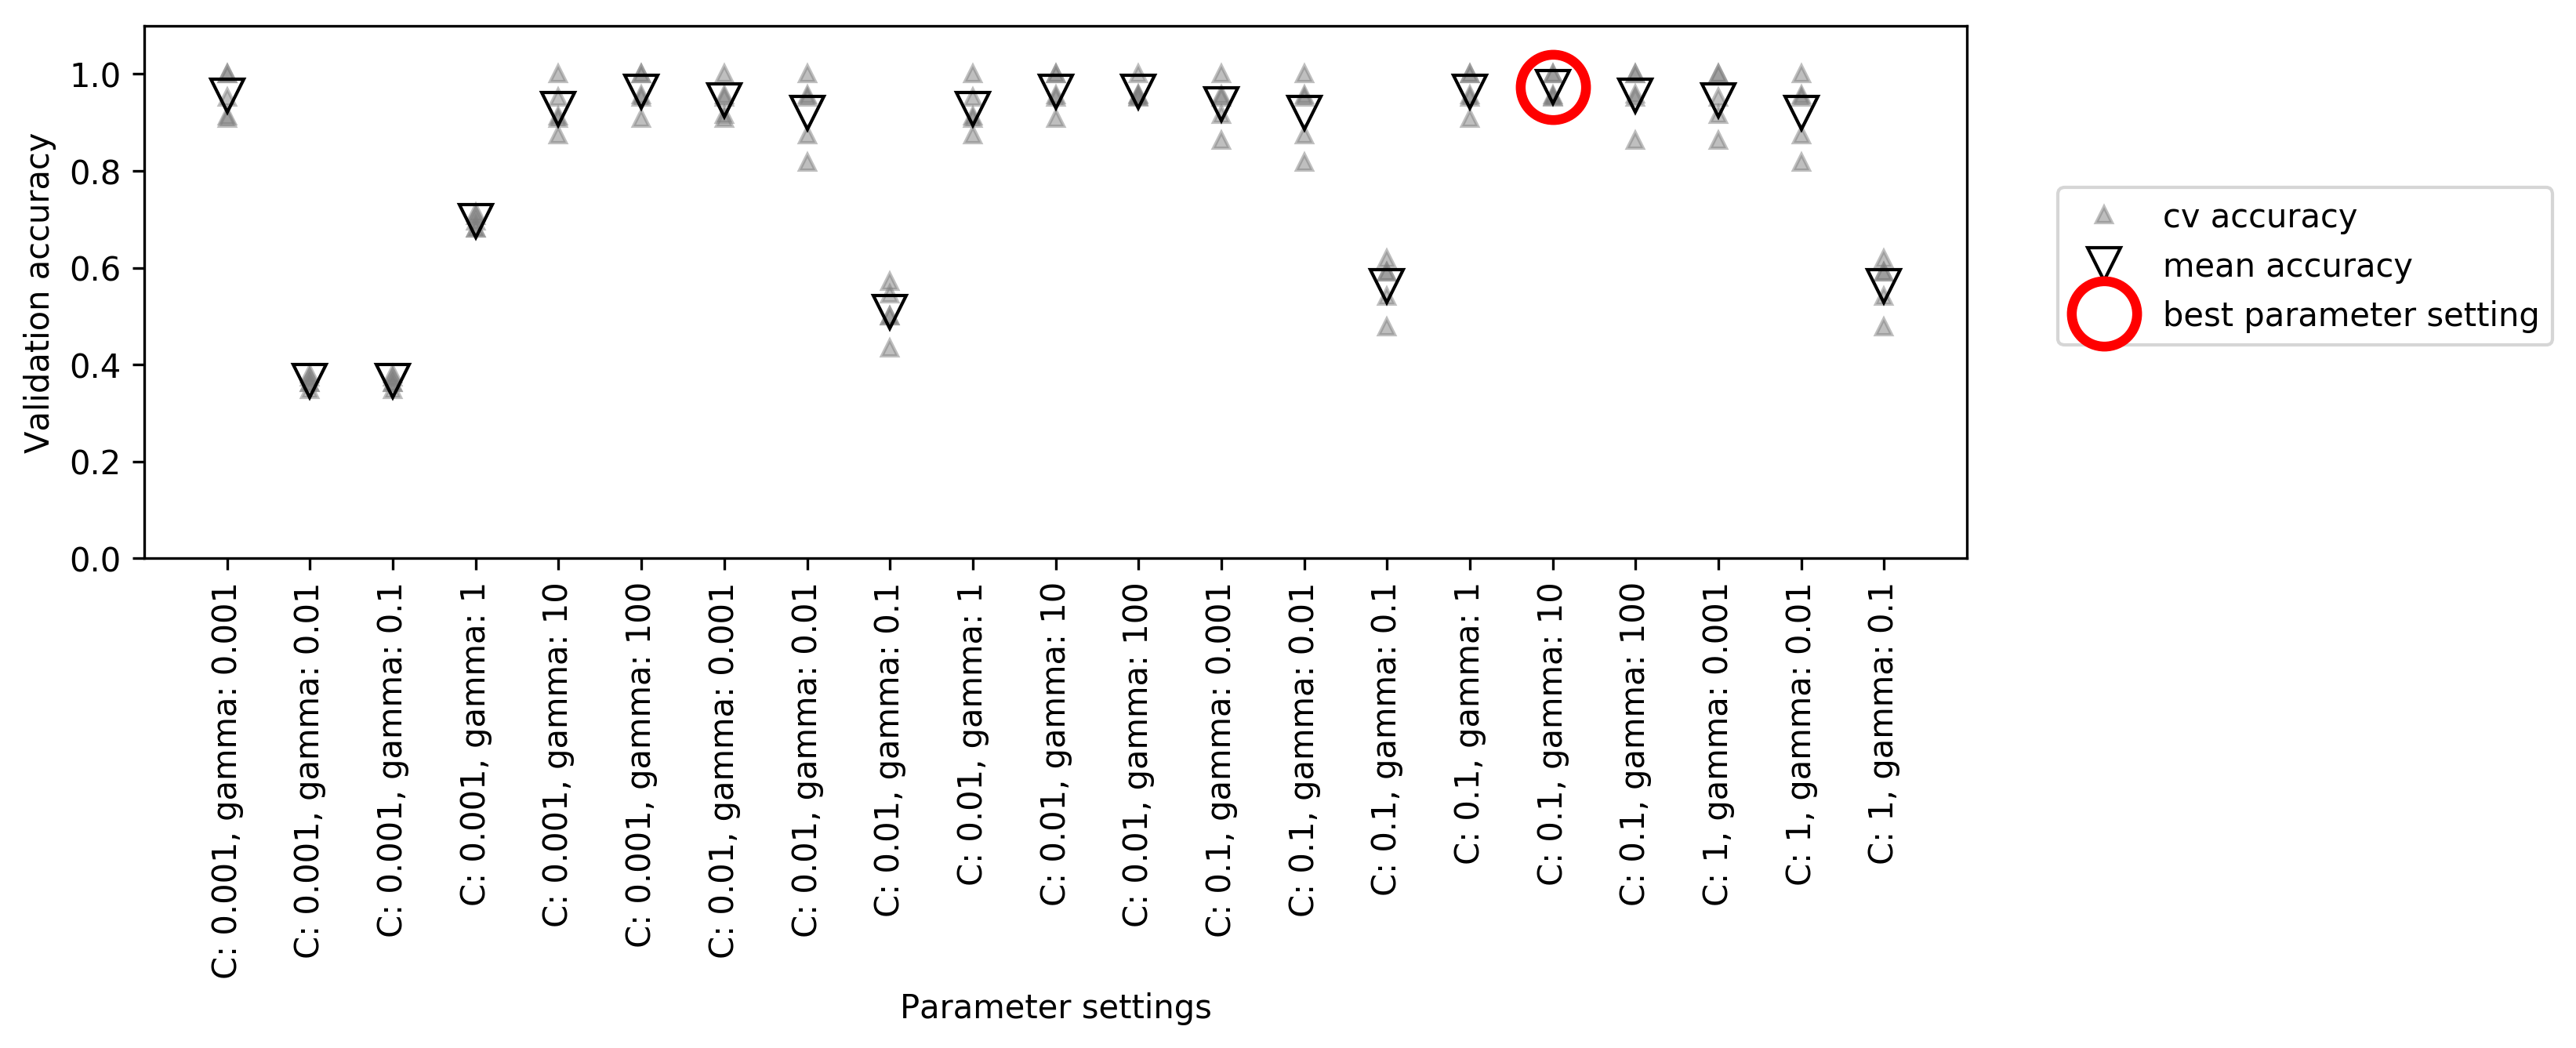

In [5]:
mglearn.plots.plot_cross_val_selection()

- 그리드 서치와 교차 검증을 사용한 매개 변수 선택과 모델 평가의 전체 작업 흐름

![process](./images/process.jpg)

- **model_selection.GridSearchCV**
  - <u>**교차 검증을 사용하는 그리드 탐색을 통한 모델 파라미터 검색 기능 제공 객체**</u>
  - 기본적으로 사용하는 교차 검증 분류기
    - 분류에는 StratifiedKFold 사용함
    - 회귀에는 KFold 사용함
  - fit을 수행한 이후에는 가장 최적의 파라미터로 만들어진 모델을 구성하고 있음.
- 다른 estimator (or 모델)를 사용하여 만들어지는 estimator를 메타 추정기(meta-estimator)라고 함.
  - GridSearchCV는 가장 널리 사용되는 메타 추정기
  - scikit-learn에서는 MetaEstimatorMixin 클래스를 상속한 모델을 메타 추정기라고 부름
  - 메타 추정기 예
    - GridSearchCV
    - RandomForest
    - GradientBoosting
    - RFE
    - ...

- 우선 모델에 들어갈 각 매개변수 값을 사전(Dict)타입으로 구성
  - 문자열 매개변수 이름을 모델(예:SVC)에 설정된 매개변수와 동일하게 맞춤  

In [8]:
param_grid = {    
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100]
}
print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


- GridSearchCV 생성
  - model_selection.GridSearchCV(estimator, param_grid, n_jobs=1, cv=None, verbose=0, return_train_score='True')
    - estimator
    - param_grid
    - n_jobs
      - Number of jobs to run in parallel
      - default: 1
      - -1 --> Using All threads
    - cv
      - None, to use the default 3-fold cross validation
      - integer, to specify the number of folds in a (Stratified)KFold.
        - fold의 개수를 cv=5와 같이 설정
      - An object to be used as a cross-validation generator.
      - An iterable yielding train, test splits.

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

estimator = SVC()
grid_search = GridSearchCV(
    estimator = estimator, 
    param_grid = param_grid, 
    n_jobs = -1, 
    cv = 5, 
    return_train_score = True
)

- 훈련 데이터와 테스트 데이터 분리

In [10]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

- 훈련 데이터만 GridSearchCV 객체에 넣어 fit을 함
  - 이 때 훈련 데이터중 일부는 내부적으로 검증 데이터 (Validation Data)로 사용됨
- GridSearchCV는 생성시 모델을 내장하므로 fit, predict, score 등의 함수를 제공
  - 모델에 따라서 predict_proba, decision_function을 제공하기도 함

In [11]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

- 모델 구성시 사용하지 않은 완전히 새로운 데이터인 X_test와 y_test를 사용하여 모델 평가

In [13]:
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Test set score: 0.97


In [14]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 100, 'gamma': 0.01}
Best cross-validation score: 0.97


- 위 두 예에서 grid_search.score() 메소드와 grid_search.best\_score\_ 속성은 매우 큰 차이
  - grid_search.score() 메소드
    - 새로운 데이터인 테스트 데이터 셋을 통한 모델 평가 점수
  - grid_search.best\_score\_ 속성
    - 훈련 데이터에 대하여 수행한 교차 검증에서의 최고 점수

In [15]:
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Best estimator:
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


#### [NOTE] 전형적인 교차 검증 그리드 서치를 통한 모델 구성 및 테스트 집합 성능 평가 코드

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

estimator = SVC()

param_grid = {    
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(
    estimator = estimator, 
    param_grid = param_grid, 
    n_jobs = -1, 
    cv = 5, 
    return_train_score = True
)

grid_search.fit(X_train, y_train)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Test set score: 0.97


#### Analyzing the result of cross-validation
- grid_search.cv\_results\_
  - 그리드 탐색에 대한 교차 검증 결과 정보가 상세히 들어 있는 속성

In [17]:
import pandas as pd
# convert to Dataframe
results = pd.DataFrame(grid_search.cv_results_)
pd.options.display.float_format = '{:,.7f}'.format

print(results.columns)
# show the first 5 rows
# display(results.head(5))
display(results)

Index(['mean_fit_time', 'mean_score_time', 'mean_test_score',
       'mean_train_score', 'param_C', 'param_gamma', 'params',
       'rank_test_score', 'split0_test_score', 'split0_train_score',
       'split1_test_score', 'split1_train_score', 'split2_test_score',
       'split2_train_score', 'split3_test_score', 'split3_train_score',
       'split4_test_score', 'split4_train_score', 'std_fit_time',
       'std_score_time', 'std_test_score', 'std_train_score'],
      dtype='object')


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,...,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.0012985,0.0005015,0.3660714,0.3660787,...,0.0002412,0.0003173,0.0113708,0.0028518
1,0.0010020,0.0004015,0.3660714,0.3660787,...,0.0000004,0.0002007,0.0113708,0.0028518
2,0.0010025,0.0003008,0.3660714,0.3660787,...,0.0000004,0.0002456,0.0113708,0.0028518
3,0.0010024,0.0001002,0.3660714,0.3660787,...,0.0000009,0.0002005,0.0113708,0.0028518
4,0.0010026,0.0004011,0.3660714,0.3660787,...,0.0003171,0.0002006,0.0113708,0.0028518
5,0.0012032,0.0003006,0.3660714,0.3660787,...,0.0002455,0.0002454,0.0113708,0.0028518
6,0.0009025,0.0003014,0.3660714,0.3660787,...,0.0002007,0.0002461,0.0113708,0.0028518
7,0.0009949,0.0004009,0.3660714,0.3660787,...,0.0000158,0.0002005,0.0113708,0.0028518
8,0.0009030,0.0003998,0.3660714,0.3660787,...,0.0002008,0.0001999,0.0113708,0.0028518
9,0.0007035,0.0003008,0.3660714,0.3660787,...,0.0002446,0.0002456,0.0113708,0.0028518


In [18]:
results2 = results[['rank_test_score', 'params', 'mean_test_score', 'std_test_score', 
                    'mean_train_score', 'std_train_score']]
results2 = results2.sort_values('rank_test_score')
display(results2)

,rank_test_score,params,mean_test_score,std_test_score,mean_train_score,std_train_score
31,1,"{'C': 100, 'gamma': 0.01}",0.9732143,0.0223995,0.9843684,0.0054851
20,2,"{'C': 1, 'gamma': 0.1}",0.9642857,0.0340769,0.9776501,0.0100842
30,2,"{'C': 100, 'gamma': 0.001}",0.9642857,0.0340769,0.9776757,0.0070319
26,2,"{'C': 10, 'gamma': 0.1}",0.9642857,0.0177687,0.9865662,0.0083555
25,2,"{'C': 10, 'gamma': 0.01}",0.9642857,0.0340769,0.9776757,0.0070319
32,6,"{'C': 100, 'gamma': 0.1}",0.9553571,0.0495662,0.9887884,0.0099945
15,6,"{'C': 0.1, 'gamma': 1}",0.9553571,0.0401043,0.9598457,0.0113043
33,8,"{'C': 100, 'gamma': 1}",0.9464286,0.0519227,1.0000000,0.0000000
21,8,"{'C': 1, 'gamma': 1}",0.9464286,0.0324799,0.9843928,0.0088664
27,10,"{'C': 10, 'gamma': 1}",0.9375000,0.0452528,0.9865906,0.0083624


- heatmap을 사용한 mean_test_score를 각 매개변수별로 시각화

[0.36607142857142855, 0.36607142857142855, 0.36607142857142855, 0.36607142857142855, 0.36607142857142855, 0.36607142857142855, 0.36607142857142855, 0.36607142857142855, 0.36607142857142855, 0.36607142857142855, 0.36607142857142855, 0.36607142857142855, 0.36607142857142855, 0.6964285714285714, 0.9196428571428571, 0.9553571428571429, 0.36607142857142855, 0.36607142857142855, 0.6964285714285714, 0.9285714285714286, 0.9642857142857143, 0.9464285714285714, 0.9196428571428571, 0.5089285714285714, 0.9285714285714286, 0.9642857142857143, 0.9642857142857143, 0.9375, 0.9196428571428571, 0.5625, 0.9642857142857143, 0.9732142857142857, 0.9553571428571429, 0.9464285714285714, 0.9196428571428571, 0.5625]

(36,)


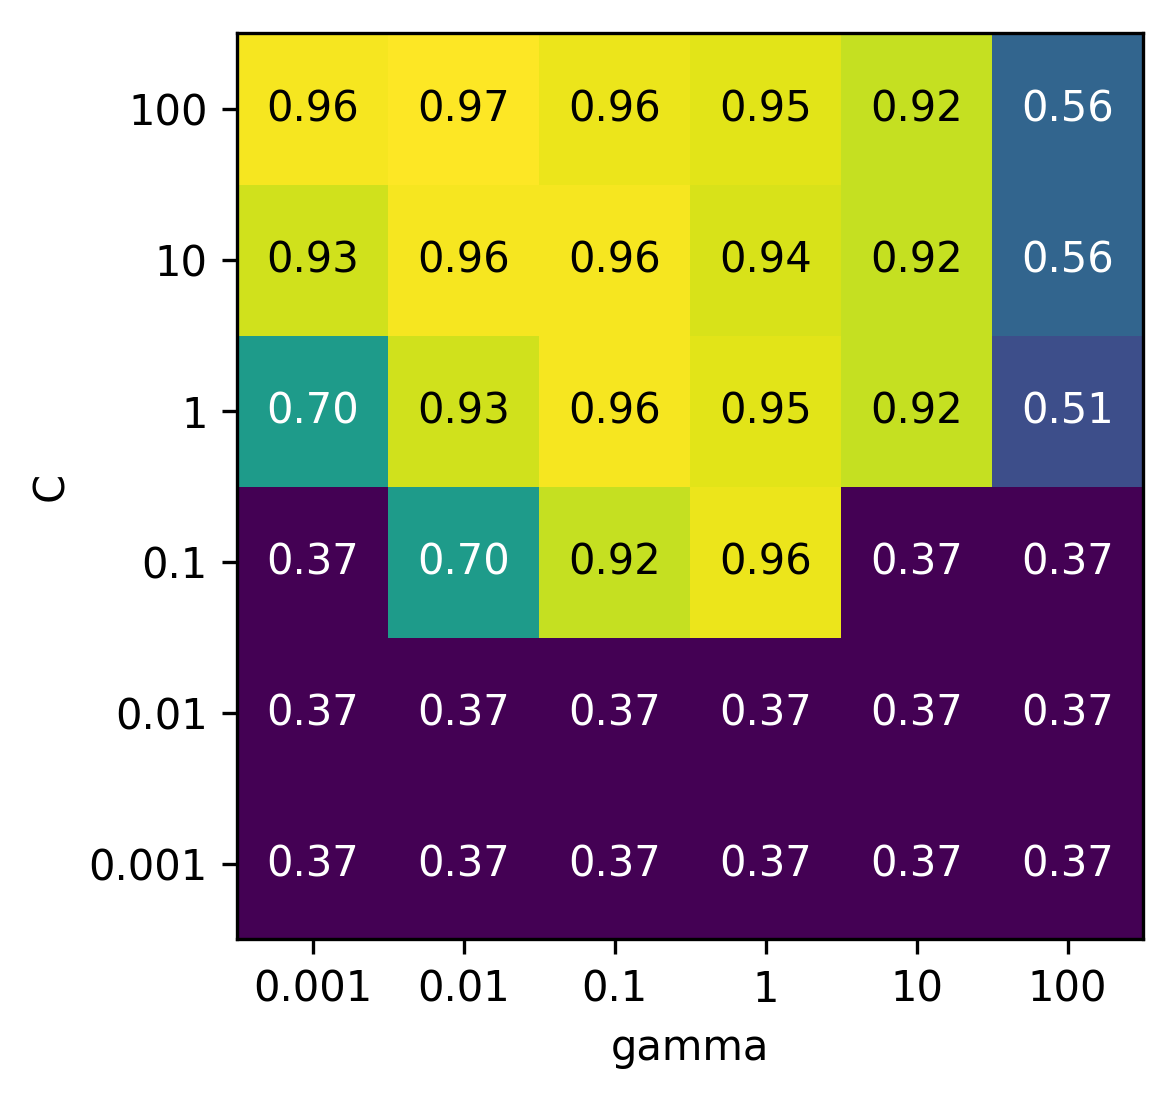

In [19]:
print([x for x in results.mean_test_score])
print()

print(results.mean_test_score.shape)

scores = np.array(results.mean_test_score).reshape(6, 6)

# plot the mean cross-validation scores
mglearn.tools.heatmap(
    scores, 
    xlabel='gamma', 
    xticklabels=param_grid['gamma'],
    ylabel='C', 
    yticklabels=param_grid['C'], 
    cmap="viridis"
)

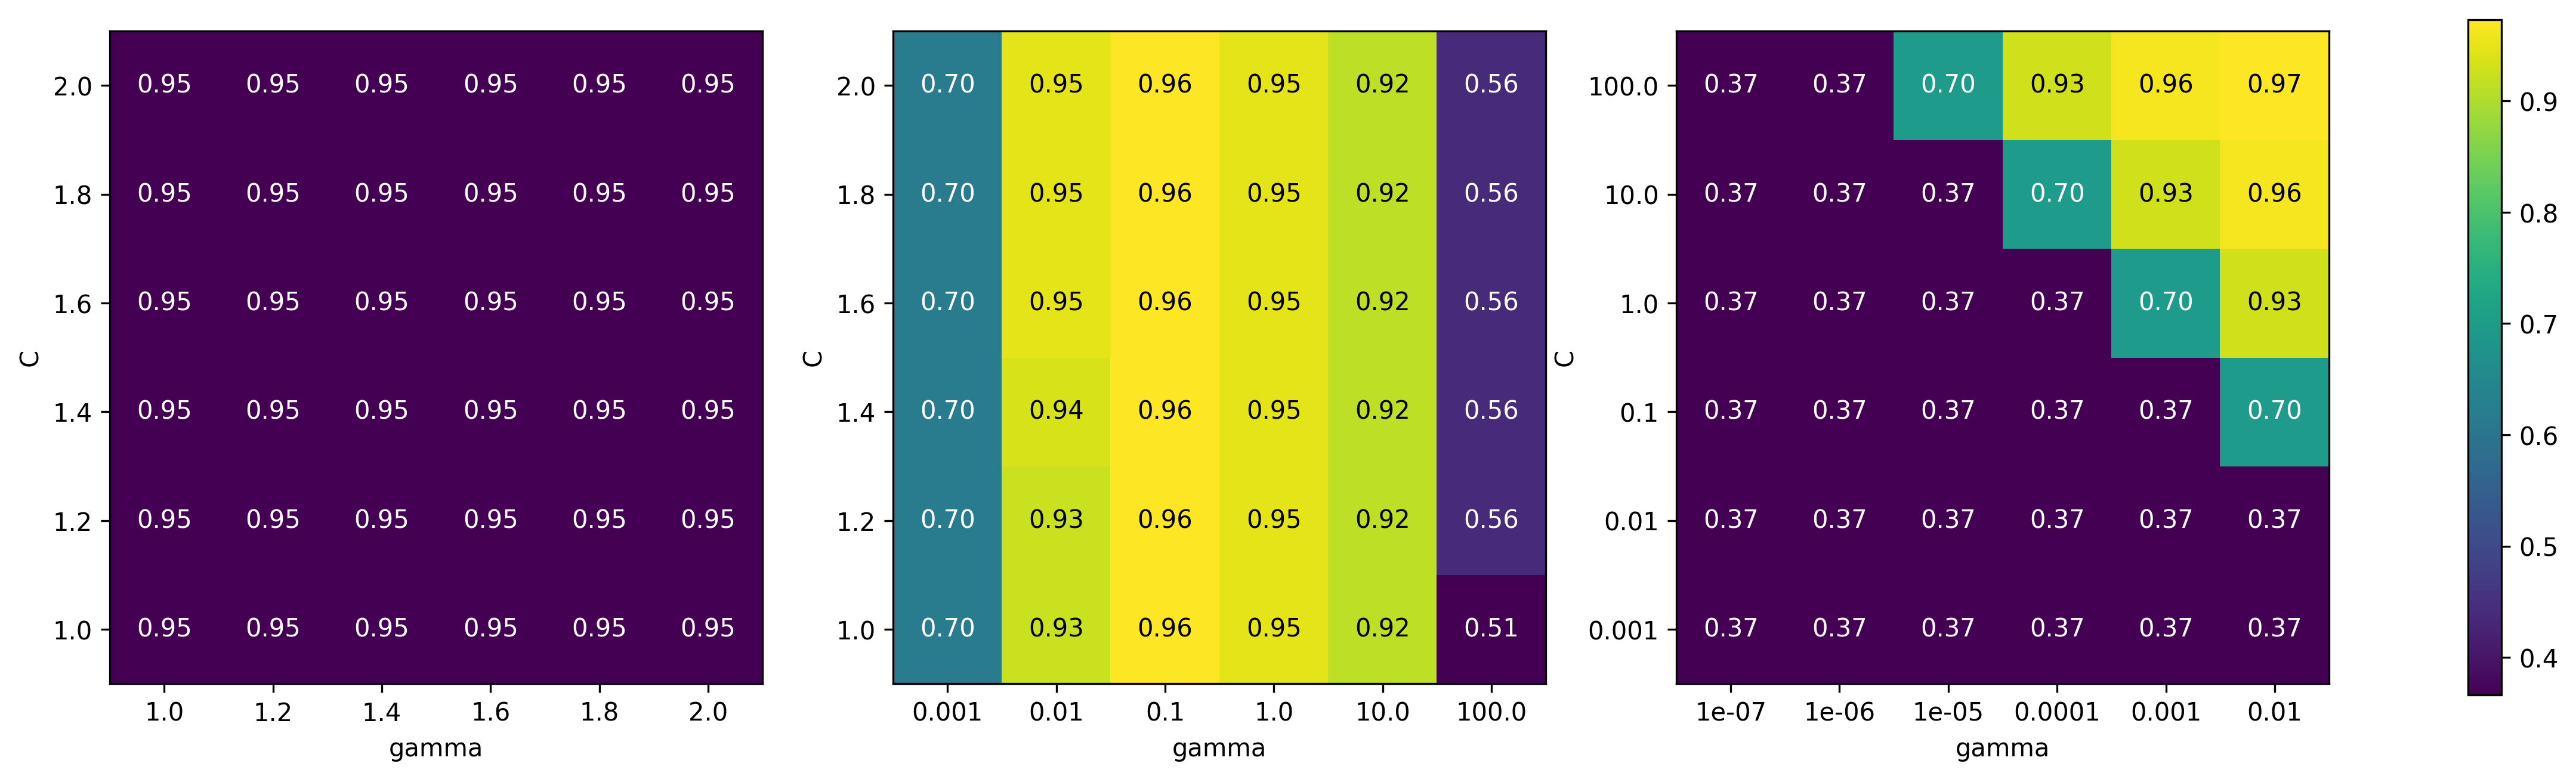

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

param_grid_linear  = {'C': np.linspace(1, 2, 6),  'gamma':  np.linspace(1, 2, 6)}
param_grid_one_log = {'C': np.linspace(1, 2, 6),  'gamma':  np.logspace(-3, 2, 6)}
param_grid_range   = {'C': np.logspace(-3, 2, 6), 'gamma':  np.logspace(-7, -2, 6)}

for param_grid, ax in zip([param_grid_linear, param_grid_one_log, param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, n_jobs=-1, cv=5)
    grid_search.fit(X_train, y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6, 6)

    # plot the mean cross-validation scores
    scores_image = mglearn.tools.heatmap(
        scores, xlabel='gamma', ylabel='C', xticklabels=param_grid['gamma'],
        yticklabels=param_grid['C'], cmap="viridis", ax=ax)

plt.colorbar(scores_image, ax=axes.tolist())

- 첫번째 그래프
  - 매개변수 C와 gamma의 스케일과 범위를 잘못 택하였음을 나타냄
  - 처음에는 더 넓은 범위의 C와 gamma 스케일 및 범위를 택하고, 이후 정확도에 따라 매개변수를 바꾸어 선택할 필요있음<br/><br/>

- 두번째 그래프
  - 세로 띠 형태를 보이므로 gamma 매개변수만 정확도에 영향을 주고 있음을 나타냄
  - 두 가지 케이스
    - C 매개변수는 전혀 중요한 역할을 못할 수 있음
    - C 매개변수의 스케일과 범위를 잘못 선택하였을 수 있음<br/><br/>
    
- 세번째 그래프
  - 그래프 왼쪽 아래에서는 변화가 없음
  - 다시 매개변수 스케일과 범위를 선택하는 과정에서 현재 선택한 것 보다 더 높은 gamma 및 C 값을 선택할 필요성 있음

#### Grid search with asymmetric parameters
- SVC
  - kernel='rbf' 일 때
    - C 매개변수, gamma 매개변수 동시 사용
  - kernel='linear' 일 때
    - C 매개변수만 사용
    - gamma 매개변수는 사용하지 않음

In [21]:
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
print("List of grids:\n{}".format(param_grid))

List of grids:
[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


In [22]:
grid_search = GridSearchCV(SVC(), param_grid, n_jobs=-1, cv=5, return_train_score=True)

grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.97


In [23]:
results = pd.DataFrame(grid_search.cv_results_)

results2 = results[['rank_test_score', 'params', 'mean_test_score', 'std_test_score', 
                    'mean_train_score', 'std_train_score']]
results2 = results2.sort_values('rank_test_score')
display(results2)

,rank_test_score,params,mean_test_score,std_test_score,mean_train_score,std_train_score
39,1,"{'C': 1, 'kernel': 'linear'}",0.9732143,0.0223995,0.9843684,0.0054851
31,1,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.9732143,0.0223995,0.9843684,0.0054851
20,3,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",0.9642857,0.0340769,0.9776501,0.0100842
30,3,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",0.9642857,0.0340769,0.9776757,0.0070319
26,3,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.9642857,0.0177687,0.9865662,0.0083555
25,3,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",0.9642857,0.0340769,0.9776757,0.0070319
40,3,"{'C': 10, 'kernel': 'linear'}",0.9642857,0.0338387,0.9888134,0.0070280
41,3,"{'C': 100, 'kernel': 'linear'}",0.9642857,0.0338387,0.9932579,0.0055055
32,9,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.9553571,0.0495662,0.9887884,0.0099945
15,9,"{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}",0.9553571,0.0401043,0.9598457,0.0113043


#### Using different cross-validation strategies with grid-search
- GridSearchCV의 인자인 cv에 스스로 정의한 다음과 같은 교차 검증 분할기 제공
  - KFold(n_splits=5)   
  - StratifiedKFold(n_splits=5)
  - ShuffleSplit(n_splits=5)
  - StratifiedShuffleSplit(n_splits=5)
- n_splits=1을 사용하는 경우
  - 훈련 데이터 세트와 검증 데이터 세트로의 분리를 한번 만 수행
  - 데이터셋이 매우 크거나 모델 구축 시간이 오래 걸릴 때 사용하는 전략

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

shuffle_split = StratifiedShuffleSplit(test_size=.8, n_splits=1)
grid_search = GridSearchCV(SVC(), param_grid, cv=shuffle_split, return_train_score=True)

grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 1, 'kernel': 'linear'}
Best cross-validation score: 0.98


In [25]:
results = pd.DataFrame(grid_search.cv_results_)

results2 = results[['rank_test_score', 'params', 'mean_test_score', 'std_test_score', 
                    'mean_train_score', 'std_train_score']]
results2 = results2.sort_values('rank_test_score')
display(results2)

,rank_test_score,params,mean_test_score,std_test_score,mean_train_score,std_train_score
39,1,"{'C': 1, 'kernel': 'linear'}",0.9777778,0.0000000,1.0000000,0.0000000
31,2,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.9666667,0.0000000,1.0000000,0.0000000
41,3,"{'C': 100, 'kernel': 'linear'}",0.9555556,0.0000000,1.0000000,0.0000000
32,3,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.9555556,0.0000000,1.0000000,0.0000000
26,3,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.9555556,0.0000000,1.0000000,0.0000000
21,3,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}",0.9555556,0.0000000,1.0000000,0.0000000
40,3,"{'C': 10, 'kernel': 'linear'}",0.9555556,0.0000000,1.0000000,0.0000000
33,8,"{'C': 100, 'gamma': 1, 'kernel': 'rbf'}",0.9444444,0.0000000,1.0000000,0.0000000
30,8,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",0.9444444,0.0000000,1.0000000,0.0000000
27,8,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}",0.9444444,0.0000000,1.0000000,0.0000000


#### Nested cross-validation
- 지금까지 살펴본 코드들의 단점
  - 처음에 원본 데이터들을 훈련 데이터와 테스트 데이터로 **한번만** 나누고 있음.
  - 원본 데이터를 훈련 데이터와 테스트 데이터로 나누는 시점도 교차 검증화 시킬 수 있음 --> **중첩 교차 검증**
- **중첩 교차 검증**
  - outer_scores = []
  - 1st Loop: 원본 데이터를 훈련(Training) 데이터와 테스트(Test) 데이터로 분리 및 순회
    - best_params = {}
    - best_score = -np.inf
    - 2nd Loop: 매개변수 그리드를 순회
      - 3rd Loop: 훈련 데이터를 다시 훈련(Training) 데이터와 검증(Validation) 데이터로 분리
      - 3rd Loop의 결과 모델을 평가하여 best_params 및 best_score 조정
    - best_params와 함께 모델 구성하여 평가결과를 outer_scores에 저장

![process](./images/nestedkfold.jpg)

In [27]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(SVC(), param_grid, cv=5)
scores = cross_val_score(grid_search, iris.data, iris.target, n_jobs=-1, cv=5)

print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [ 0.967  1.     0.967  0.967  1.   ]
Mean cross-validation score:  0.98


- 위 코드 설명
  - 매개 변수 조합: 6 \* 6 = 36
  - 바깥 루프: 5개 분할
  - 안쪽 루프: 5개 분할
  - 모델 생성 횟수: 36 \* 5 \* 5 = 900

In [28]:
def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
    outer_scores = []
    outer_best_params = []
    
    # for each split of the data in the outer cross-validation
    # (split method returns indices of training and test part)
    for training_samples, test_samples in outer_cv.split(X, y):
        # find best parameter using inner cross-validation
        best_parms = {}
        best_score = -np.inf

        # iterate over parameters
        for parameters in parameter_grid:
            # accumulate score over inner splits
            cv_scores = []

            # iterate over inner cross-validation
            for inner_train, inner_test in inner_cv.split(X[training_samples], y[training_samples]):
                # build classifier given parameters and training data
                clf = Classifier(**parameters)
                clf.fit(X[inner_train], y[inner_train])
                # evaluate on inner test set
                score = clf.score(X[inner_test], y[inner_test])
                cv_scores.append(score)

                # compute mean score over inner folds
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                # if better than so far, remember parameters
                best_score = mean_score
                best_params = parameters

        # build classifier on best parameters using outer training set
        clf = Classifier(**best_params)
        clf.fit(X[training_samples], y[training_samples])

        # evaluate
        outer_scores.append(clf.score(X[test_samples], y[test_samples]))
        outer_best_params.append(best_params)
    return np.array(outer_scores), outer_best_params

In [29]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold

scores, params = nested_cv(
    iris.data, 
    iris.target, 
    StratifiedKFold(5), 
    StratifiedKFold(5), 
    SVC,
    ParameterGrid(param_grid)
)

print("Cross-validation scores: {}".format(scores))
print("Mean cross-validation score: ", scores.mean())
print("best params: {}".format(params))

Cross-validation scores: [ 0.967  1.     0.967  0.967  1.   ]
Mean cross-validation score:  0.98
best params: [{'C': 100, 'gamma': 0.01}, {'C': 100, 'gamma': 0.01}, {'C': 100, 'gamma': 0.01}, {'C': 100, 'gamma': 0.01}, {'C': 100, 'gamma': 0.01}]


#### Parallelizing cross-validation and grid search
- 다중 CPU 코어 or 다중 GPU 코어 사용
- 사용가능한 프레임워크
  - ipyparallel
    - https://ipyparallel.readthedocs.io
  - spark-sklearn
    - https://github.com/databricks/spark-sklearn